<a href="https://colab.research.google.com/github/nelrob/movie-ranking-prediction/blob/main/Movie_Ranking_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries and Data

In [1]:
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.2/96.2 KB 5.6 MB/s eta 0:00:00


In [2]:
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

import numpy as np
import tensorflow as tf
from typing import Dict, Text

import warnings
warnings.simplefilter('ignore')

In [3]:
print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.11.0


# Data pre-processing

In [4]:
# Load movielens 100k dataset from Tensorflow datasets
ratings = tfds.load("movielens/100k-ratings", split="train")

# Create a map of the columns needed
ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
    "user_rating": x["user_rating"]
})

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/100000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/movielens/100k-ratings/0.1.1.incompleteTP0K0L/movielens-train.tfrecord*...…

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Dataset movielens downloaded and prepared to /root/tensorflow_datasets/movielens/100k-ratings/0.1.1. Subsequent calls will reuse this data.


### Visualise the dataset

In order to visualise the dataset, `ratings` needs to be converted into a 2d array,

In [5]:
ratings_array = []

for rating in ratings:
    # extracts values from the Tensor objects
    movie_title = rating['movie_title'].numpy()
    movie_title = movie_title.decode('utf-8')
    
    user_id = int(rating['user_id'].numpy())
    user_rating = rating['user_rating'].numpy()
    
    ratings_array.append([movie_title, user_id, user_rating])

In [6]:
# first 10 movies of ratings array
ratings_array[:10]

[["One Flew Over the Cuckoo's Nest (1975)", 138, 4.0],
 ['Strictly Ballroom (1992)', 92, 2.0],
 ['Very Brady Sequel, A (1996)', 301, 4.0],
 ['Pulp Fiction (1994)', 60, 4.0],
 ['Scream 2 (1997)', 197, 3.0],
 ['Crash (1996)', 601, 4.0],
 ['Aladdin (1992)', 710, 3.0],
 ['True Romance (1993)', 833, 2.0],
 ['Bob Roberts (1992)', 916, 5.0],
 ['Starship Troopers (1997)', 940, 2.0]]

...and then a Pandas DataFrame.

In [7]:
import pandas as pd

df = pd.DataFrame(ratings_array, columns = ['movie_title', 'user_id', 'user_rating'])

In [8]:
df.head(5)

,movie_title,user_id,user_rating
0,One Flew Over the Cuckoo's Nest (1975),138,4.0
1,Strictly Ballroom (1992),92,2.0
2,"Very Brady Sequel, A (1996)",301,4.0
3,Pulp Fiction (1994),60,4.0
4,Scream 2 (1997),197,3.0


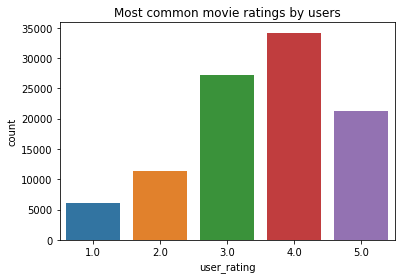

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='user_rating', data=df)
plt.title('Most common movie ratings by users')
plt.show()

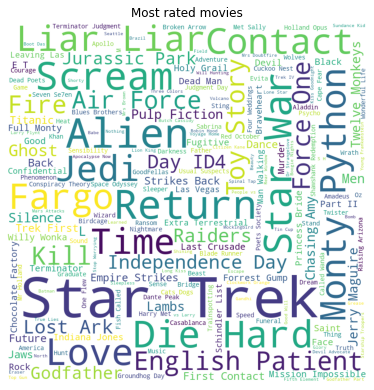

In [10]:
from wordcloud import WordCloud, STOPWORDS

titles = df['movie_title'].tolist() # convert to list of movie title strings

stopwords = STOPWORDS # filter common filler words in movie titles
wordcloud = WordCloud(width=800, height=800, stopwords=stopwords, background_color="white", min_font_size=10).generate(' '.join(titles))

plt.figure(figsize=(5, 5), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.title('Most rated movies')
plt.show()

# Movie Ranking Predictor Model

### Split into training and testing

In [11]:
# Set random seed for repeatability
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

# 80-20 split in training and testing data 
train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

Create a map of unique movie titles and user IDs

In [12]:
movie_titles = ratings.batch(100_000).map(lambda x: x["movie_title"])
user_ids = ratings.batch(100_000).map(lambda x: x["user_id"])

unique_movie_titles = np.unique(np.concatenate(list(movie_titles)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

### Tensorflow ranking model

In [13]:
class RankingModel(tf.keras.Model):

  def __init__(self):
    super().__init__()
    embedding_dimension = 32

    # Compute embeddings for users
    self.user_embeddings = tf.keras.Sequential([
      # convert user IDs to embeddings
      tf.keras.layers.StringLookup(
        vocabulary=unique_user_ids, mask_token=None),
      # embed user IDs
      tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
    ])

    # Compute embeddings for movies
    self.movie_embeddings = tf.keras.Sequential([
      # convert movie titles to embeddings
      tf.keras.layers.StringLookup(
        vocabulary=unique_movie_titles, mask_token=None),
      # embed movie titles
      tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
    ])

    # Compute predictions
    self.ratings = tf.keras.Sequential([
      # learn multiple dense layers
      tf.keras.layers.Dense(256, activation="relu"),
      tf.keras.layers.Dense(64, activation="relu"),
      # make rating predictions in the final layer
      tf.keras.layers.Dense(1)
  ])
  
  # Function to process inputs and return final output
  def call(self, inputs):

    user_id, movie_title = inputs

    user_embedding = self.user_embeddings(user_id)
    movie_embedding = self.movie_embeddings(movie_title)

    return self.ratings(tf.concat([user_embedding, movie_embedding], axis=1))

### Loss and metrics

Loss - Mean Absolute Error (MAE): 
measures the average magnitude of the errors between the predicted and true ratings. 

Metrics - Mean Absolute Percentage Error (MAPE):
measures the mean percentage error of the predictions. 

In [14]:
# Create ranking task with MAE loss and MAPE metrics
task = tfrs.tasks.Ranking(loss=tf.keras.losses.MeanAbsoluteError(),
                          metrics=[tf.keras.metrics.MeanAbsolutePercentageError()])

### Movie Predictor Model

In [15]:
class MoviePredictorModel(tfrs.models.Model):

  def __init__(self):
    super().__init__()

    # Create instance of TFRS Ranking
    self.ranking_model: tf.keras.Model = RankingModel()
    self.task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
      loss = tf.keras.losses.MeanAbsoluteError(),
      metrics=[tf.keras.metrics.MeanAbsolutePercentageError()]
    )

  # Function to call the ranking_model on the input features "user_id" and "movie_title"
  def call(self, features: Dict[str, tf.Tensor]) -> tf.Tensor:
    return self.ranking_model(
        (features["user_id"], features["movie_title"]))

  # Function to compute model loss 
  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    # remove the label "user_rating" from features
    labels = features.pop("user_rating")
    
    # get the rating predictions from the call function
    rating_predictions = self(features)

    return self.task(labels=labels, predictions=rating_predictions)

# Model fitting and evaluation

In [16]:
# Shuffle, batch, and cache training and testing data
cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

Implement early stopping to stop training once the model performance stops improving.

In [17]:
from tensorflow.keras.callbacks import EarlyStopping

model = MoviePredictorModel()
# Define early stopping 
early_stopping = EarlyStopping(monitor='val_loss', patience=30)

In [18]:
# Compile model with Adam optimizer
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

# Run the MoviePredictorModel
history = model.fit(
    cached_train,
    validation_data=cached_test,
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50
10/10 [==============================] - 13s 655ms/step - mean_absolute_percentage_error: 96.2065 - loss: 3.4048 - regularization_loss: 0.0000e+00 - total_loss: 3.4048 - val_mean_absolute_percentage_error: 90.0960 - val_loss: 3.2400 - val_regularization_loss: 0.0000e+00 - val_total_loss: 3.2400
Epoch 2/50
10/10 [==============================] - 1s 63ms/step - mean_absolute_percentage_error: 81.1006 - loss: 2.9355 - regularization_loss: 0.0000e+00 - total_loss: 2.9355 - val_mean_absolute_percentage_error: 66.2996 - val_loss: 2.5157 - val_regularization_loss: 0.0000e+00 - val_total_loss: 2.5157
Epoch 3/50
10/10 [==============================] - 1s 65ms/step - mean_absolute_percentage_error: 51.1535 - loss: 1.8075 - regularization_loss: 0.0000e+00 - total_loss: 1.8075 - val_mean_absolute_percentage_error: 35.4063 - val_loss: 1.0034 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.0034
Epoch 4/50
10/10 [==============================] - 1s 56ms/step - mean_absolute_pe

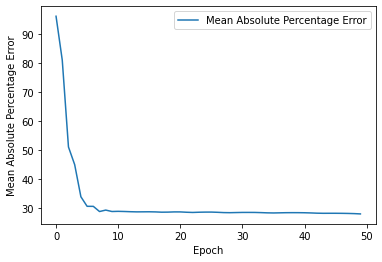

In [19]:
# Plot the mean absolute percentage error and total loss
plt.plot(history.history['mean_absolute_percentage_error'], label='Mean Absolute Percentage Error')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Percentage Error')
plt.legend()
plt.show()

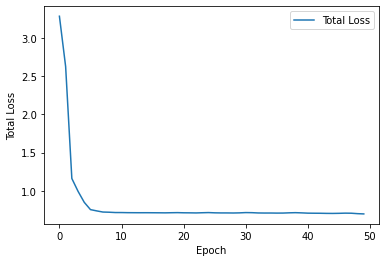

In [20]:
# Plot the mean absolute error and total loss
plt.plot(history.history['loss'], label='Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.legend()
plt.show()

In [21]:
model.evaluate(cached_test, return_dict=True)

5/5 [==============================] - 0s 5ms/step - mean_absolute_percentage_error: 28.8990 - loss: 0.7265 - regularization_loss: 0.0000e+00 - total_loss: 0.7265


{'mean_absolute_percentage_error': 28.898956298828125,
 'loss': 0.7254838943481445,
 'regularization_loss': 0,
 'total_loss': 0.7254838943481445}

# Model testing

In [22]:
# Show a random list of movies rated by user 33
user_id = df[df['user_id'] == 33]
user_random_movies = user_id.sample(n=min(10, len(user_id)), random_state=5)
print(user_random_movies)

                                  movie_title  user_id  user_rating
85650                     Dante's Peak (1997)       33          4.0
3511                         Liar Liar (1997)       33          3.0
75515                 Devil's Own, The (1997)       33          3.0
81744                         Mad City (1997)       33          3.0
84498                        Game, The (1997)       33          4.0
90376                Conspiracy Theory (1997)       33          4.0
56824                        Soul Food (1997)       33          3.0
41916                          Contact (1997)       33          4.0
9730               Tomorrow Never Dies (1997)       33          4.0
2992   I Know What You Did Last Summer (1997)       33          4.0


### Save and interact with the model 

In [23]:
tf.saved_model.save(model, "MovieRankingModel")

In [24]:
MovieRankingsPredict = tf.saved_model.load("MovieRankingModel")

In [25]:
# extract movie titles from the dataset
movies = ratings.map(lambda x: x["movie_title"])
movies = set([str(x.numpy().decode()) for x in movies])

In [26]:
import random

user_pred = input("Enter a user id: ")

# generate a random subset of movie titles
random_movies = random.sample(movies, 10)

result = {}
for movie_title in random_movies:
    result[movie_title] = MovieRankingsPredict({
        "user_id": np.array([user_pred]),
        "movie_title": np.array([movie_title])
    })

print(f"\n- User " + user_pred + "'s predicted ratings for 10 random movies: ")
for title, score in sorted(result.items(), key=lambda x: x[1], reverse=True):
    print(f"{title}: {score.numpy()[0][0]}")

Enter a user id: 33

- User 33's predicted ratings for 10 random movies: 
Quiet Room, The (1996): 4.366078853607178
Fast, Cheap & Out of Control (1997): 4.170469284057617
Adventures of Robin Hood, The (1938): 4.114421367645264
Little Princess, The (1939): 3.8604559898376465
Bulletproof (1996): 3.385737657546997
Mixed Nuts (1994): 2.890211820602417
Etz Hadomim Tafus (Under the Domin Tree) (1994): 2.759622573852539
Big Bully (1996): 2.396414041519165
Phat Beach (1996): 2.0028111934661865
Tough and Deadly (1995): 1.5510845184326172
